## Использование библиотек для решения задач оптимизации

Вторая часть лабораторной работы

In [1]:
import utils
from utils.config import *
from utils.graphics import *

### Задание 3

Изучить использование готовых методов оптимизации из SciPy (scipy.optimize.minimize, scipy.optimize.least_squares)

[дока с scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

[дока с scipy.optimize.least_squares](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

подсказочка по документации scipy

Аргументы least_squares:
* `ftol` - eps для функции ошибки
* `xtol` - eps для разницы независимых переменных
* `gtol` - eps для нормы градиента
* `max_nfev` - максимальное количество итераций

Объект OptimizeResult:
* `cost` - значение функции ошибки
* `optimality` - норма градиента
* `nfev` - количество вызовов целевой функции
* `njev` - количество подсчитанных якобианов

Начнем с наименьших квадратов.

(1) Парабола

$f_1(x) = 0.5x^2-4x+1$

$f'_1(x) = x-4$

(2) Полином 6 степени

$f_2(x) = 0.000018x^6-0.0004x^5-0.005x^4+0.1x^3+0.5x^2-5x+1$

$f'_2(x) = 0.000108x^5-0.002x^4-0.02x^3+0.3x^2+x-5$

In [2]:
import functions
from functions.torch.Polynomial import TPoly

parabola_points = [
    torch.tensor([1, 8]),
    torch.tensor([-7, 4]),
    torch.tensor([1, 0])
]

c = list(map(lambda x: torch.tensor(x), [0.000018, -0.0004, -0.005, 0.1, 0.5, -5, 1]))

polynomial_points = []

for p in np.linspace(-25, 25, 60):
    polynomial_points.append(torch.tensor([TPoly(torch.tensor(p), c), p]))

### Задание 3, пункт (a)

Рассмотреть возможность использования PyTorch для вычисления градиента.

Конечные разности - это, конечно, хорошо, но по количеству вычислений можно выиграть, используя PyTorch

(1) Парабола

$f_1(x) = 0.5x^2-4x+1$

$f'_1(x) = x-4$

Наиболее успешный результат
Успешно: True
Оптимальность: 3.0012699027524624e-09
Функция ошибки: 8.786884094639206e-15
Подобранные параметры: [ 0.49996621 -3.99974423  0.9998074 ]
Количество вызовов функции: 16
Посчитано якобианов: 16
Код возврата: 1


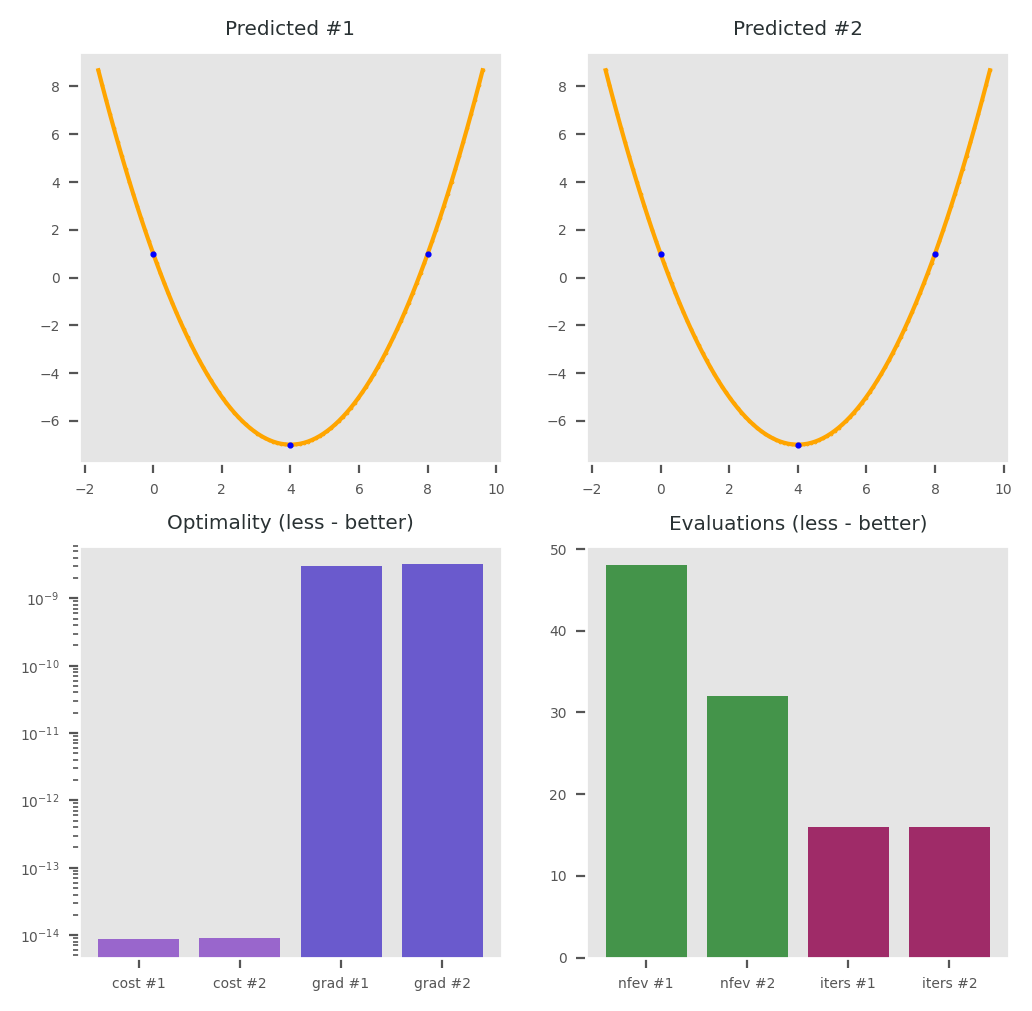

In [3]:
from functions.torch.LeastSquaresMethod import TLeastSquares

m = TLeastSquares(TPoly, parabola_points)
p1 = least_squares(m, torch.zeros(3)) # 2-point grad scipy's algorithm
p2 = least_squares(m, torch.zeros(3), jac=m.jacobian) # pytorch autograd
least_squares_comp(p1, p2, TPoly, parabola_points)

Покажем, что конечные разности - все-таки не всегда хорошо.

(2) Полином 6 степени

$f_2(x) = 0.000018x^6-0.0004x^5-0.005x^4+0.1x^3+0.5x^2-5x+1$

$f'_2(x) = 0.000108x^5-0.002x^4-0.02x^3+0.3x^2+x-5$

In [4]:
m = TLeastSquares(TPoly, polynomial_points)
p3 = least_squares(m, torch.zeros(7)) # 2-point grad scipy's algorithm
least_squares_print_status(p3)

Успешно: True
Оптимальность: 51709182665.25509
Функция ошибки: 904.1037480665854
Подобранные параметры: [ 1.76303038e-05 -3.99137431e-04 -4.66782966e-03  9.93379846e-02
  4.27811987e-01 -4.91159283e+00  3.23155767e+00]
Количество вызовов функции: 24
Посчитано якобианов: 12
Код возврата: 3


Сравним с PyTorch Autograd

Наиболее успешный результат
Успешно: True
Оптимальность: 6.006240557751718e-06
Функция ошибки: 1.1801439799430385e-19
Подобранные параметры: [ 1.80000006e-05 -3.99999988e-04 -4.99999987e-03  1.00000001e-01
  4.99999999e-01 -4.99999997e+00  9.99999989e-01]
Количество вызовов функции: 29
Посчитано якобианов: 29
Код возврата: 3


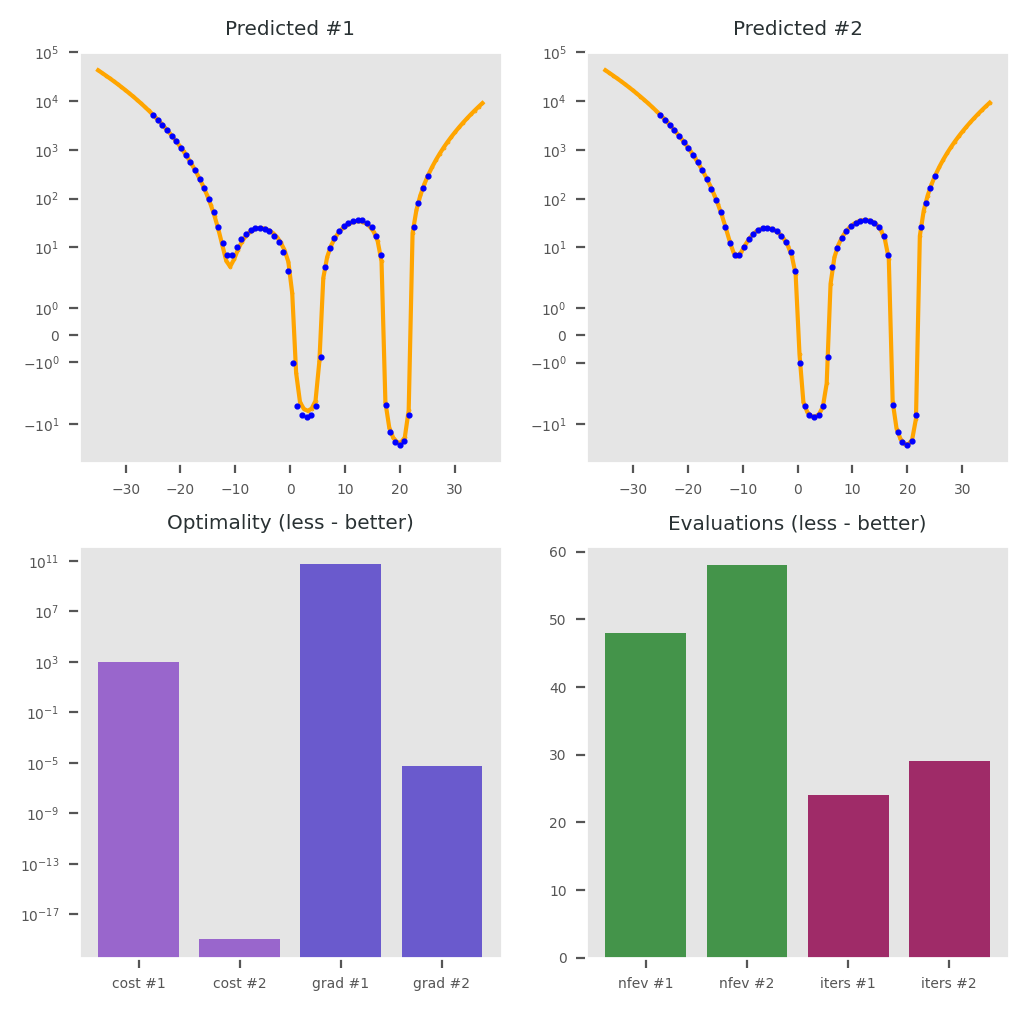

In [5]:
m = TLeastSquares(TPoly, polynomial_points)
p4 = least_squares(m, torch.zeros(7), jac=m.jacobian) # pytorch autograd
least_squares_comp(p3, p4, TPoly, polynomial_points, log=True)

Как видно из графиков, конечные разности могут быть неточными (разумеется), и при большом количестве точек значение функции ошибки может оказаться очень большим, поэтому градиент лучше считать по-человечески.

Проверим метод minimize на функции Розенброка.

Для начала попробуем метод сопряженных градиентов

In [6]:
from functions.torch.Rozenbrock import TRozenbrock

m = TRozenbrock()
r1 = minimize(m, torch.zeros(2), method="CG") # метод сопряженных градиентов
minimize_print_status(r1) # норм

Успешно: True
Значение функции: 2.0085382242752512e-11
Точка минимума: [0.99999552 0.99999103]
Количество итераций метода: 21
Количество вызовов функции: 165
Посчитано якобианов: 55
Комментарий: Optimization terminated successfully.


Результат с PyTorch Autograd
Успешно: True
Значение функции: 6.317906202238761e-11
Точка минимума: [0.99999205 0.99998409]
Количество итераций метода: 18
Количество вызовов функции: 42
Посчитано якобианов: 42
Комментарий: Optimization terminated successfully.


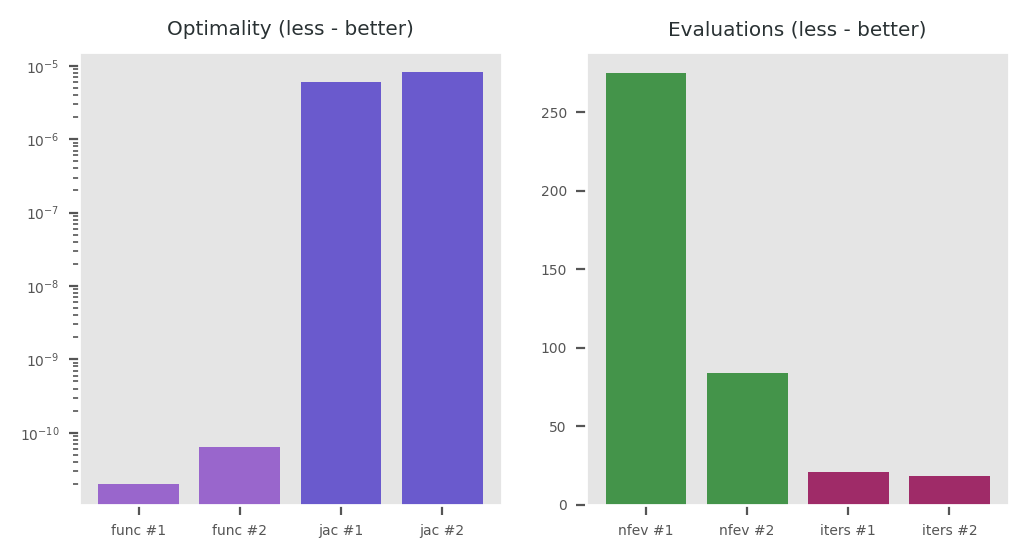

In [7]:
m = TRozenbrock()
r2 = minimize(m, torch.zeros(2), method="CG", jac=m.jacobian)
minimize_comp(r1, r2) # норм

Мы нашли приближение одинаковых порядков, но имеем намного меньше вычислений -> более быструю работу метода.

Теперь попробуем метод BFGS (мы помним, что он очень капризный)

In [8]:
m = TRozenbrock()
r3 = minimize(m, torch.tensor([-5., -5.]), method="BFGS")
minimize_print_status(r3)

Успешно: True
Значение функции: 2.0292507787928942e-11
Точка минимума: [0.9999955  0.99999098]
Количество итераций метода: 73
Количество вызовов функции: 282
Посчитано якобианов: 94
Комментарий: Optimization terminated successfully.


Результат с PyTorch Autograd
Успешно: True
Значение функции: 8.192394578437272e-20
Точка минимума: [1. 1.]
Количество итераций метода: 73
Количество вызовов функции: 94
Посчитано якобианов: 94
Комментарий: Optimization terminated successfully.


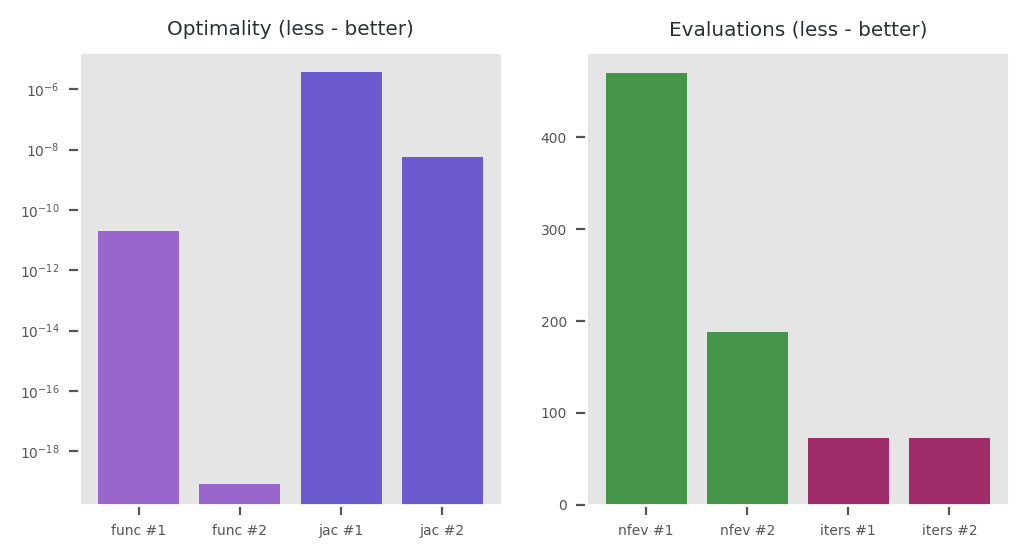

In [9]:
m = TRozenbrock()
r4 = minimize(m, torch.tensor([-5., -5.]), method="BFGS", jac=m.jacobian)
minimize_comp(r3, r4) # те же 73 итерации, но ошибка на порядки меньше и ответ точнее. меньше вызовов самой функции в два раза.

Разумеется, можно писать функции вычисления градиента/якобиана/гессиана самому, но для каких-то сложных функций это может быть сильно затранее, чем пройти по графу вычислений в обратную сторону. Естественное применение подхода автоматического подсчета градиента - нейронные сети.

### Задание 3, пункт (b)

Исследовать эффективность и сравнить с собственными реализациями из 3 работы.

In [10]:
import utils.lab3 as lab3

m = lab3.LeastSquaresMethod(polynomial_points, lab3.Poly)
gn = lab3.GaussNewtonMover(m, 0.94)
stop_cond = lambda x, **kwargs: gn.function.get_error(x) < 1e-8 or np.abs(np.linalg.norm(kwargs['prev_x'] - x)) < 1e-8
regr = lab3.regression(gn, np.zeros(7), stop_cond)

print("result", regr[-1])
print("iterations", len(regr) - 1)
print("error", gn.function.f(regr[-1]))


result [ 1.80000006e-05 -3.99999989e-04 -4.99999987e-03  1.00000001e-01
  4.99999999e-01 -4.99999999e+00  9.99999997e-01]
iterations 7
error 2.1382900274235557e-10


In [11]:
m = TLeastSquares(TPoly, polynomial_points)
p4 = least_squares(m, torch.zeros(7), jac=m.jacobian, method="dogbox")
least_squares_print_status(p4)

Успешно: True
Оптимальность: 5.151650099793672e-06
Функция ошибки: 1.2807712919203958e-19
Подобранные параметры: [ 1.80000006e-05 -3.99999988e-04 -4.99999986e-03  1.00000001e-01
  4.99999997e-01 -4.99999997e+00  9.99999994e-01]
Количество вызовов функции: 29
Посчитано якобианов: 29
Код возврата: 3


In [12]:
m = lab3.LeastSquaresMethod(polynomial_points, lab3.Poly)
dl = lab3.DogLegMover(m, initial_tr=100, eta=1e-10)
stop_cond = lambda x, **kwargs: dl.function.get_error(x) < 1e-8 or np.abs(np.linalg.norm(kwargs['prev_x'] - x)) < 1e-8
regr = lab3.regression(dl, np.zeros(7), stop_cond)

print("result", regr[-1])
print("iterations", len(regr) - 1)
print("error", dl.function.f(regr[-1]))

result [ 1.80000006e-05 -3.99999990e-04 -4.99999989e-03  1.00000001e-01
  5.00000000e-01 -5.00000000e+00  1.00000000e+00]
iterations 1
error 2.236696376343387e-21


Промежуточный вывод: иногда полезно писать оптимизацию линейных квадратов руками

Задача минимизации суммы квадратов посложнее (линейная регрессия, 15 параметров)

In [13]:
import utils.xloader
import functions.vanilla.LinearCombination as LinearCombination
from functions.torch.LinearCombination import TLinearCombination

death_rate_dataset = utils.xloader.points('x28.txt')
print("dataset size:", len(death_rate_dataset))
least_squares_methods_comp(death_rate_dataset, LinearCombination, TLinearCombination, 0.98, ) # lm instead of dogbox

dataset size: 60
--- Gauss-Newton ---
result [ 1.21787447e+00 -1.72174865e+00  1.82776578e+00  7.67173470e+00
  1.30863016e+02 -7.66133234e+00  9.80536812e-01  1.24942949e-02
  3.30483546e+00  1.23923968e+00  2.24950996e+00 -6.88091495e-01
  1.59690185e+00  3.23696826e-02  2.42829833e+00]
iterations 1000
error 0.20355606
--- LM ---
Успешно: True
Оптимальность: 97486.94109749794
Функция ошибки: 101904414.03303881
Подобранные параметры: [ 1.31094746e+00 -2.11074593e+00  1.08891801e+00  5.72750283e+00
  1.30382934e+02 -1.48788565e+01  1.70160850e+00  1.21140499e-02
  3.44284322e+00  2.91503298e+00  2.95552644e+00 -1.22275151e+00
  2.72534379e+00 -9.03781741e-02  2.68590236e+00]
Количество вызовов функции: 26
Посчитано якобианов: 20
Код возврата: 2
--- Dogleg ---
result [ 1.21836603e+00 -1.71746629e+00  1.82942209e+00  7.66037815e+00
  1.30661530e+02 -7.64886816e+00  9.83551312e-01  1.25412580e-02
  3.30063575e+00  1.24001634e+00  2.24705721e+00 -6.87187496e-01
  1.59435992e+00  3.18349431

Зато SciPy+PyTorch должны справляться намного быстрее, чем обычные реализации методов на Python из-за использования нативного кода и GPU (последнее мы не демонстрировали, но такая возможность имеется).

К тому же мы нигде не подбирали параметры для `scipy.least_squares()`, что в каком-то смысле тоже является плюсом - встроенные константы и планировщики являются хорошими, и нам не нужно подбирать их самостоятельно. Из минусов - патологические случаи несхождения методов исправить можно будет только анализируя и внося правки в датасет.

Сравнение BFGS из лабы 3 и `scipy.minimize()`

In [24]:
c = np.array([2.5, 5])
search = lab3.Linsearch(max_lr=15, step=0.005)
h = np.linalg.inv(functions.vanilla.Rozenbrock.hessian(c))
m = lab3.BFGSMover(functions.vanilla.Rozenbrock, search, hinv=h, c1=0.000001, c2=0.2)

stop_cond = lambda x, **kwargs: m.function.f(x) < 1e-8 or np.abs(np.linalg.norm(kwargs['prev_x'] - x)) < 1e-8
regr = lab3.regression(m, c, stop_cond)

print("result", regr[-1])
print("iterations", len(regr) - 1)
print("value", m.function.f(regr[-1]))

result [1.00003425 1.00007122]
iterations 19
value 1.907514582888314e-09


In [15]:
f = TRozenbrock()
r = minimize(f, c, method="BFGS", jac=f.jacobian)
minimize_print_status(r) # норм

Успешно: True
Значение функции: 8.104268803787415e-17
Точка минимума: [1. 1.]
Количество итераций метода: 27
Количество вызовов функции: 33
Посчитано якобианов: 33
Комментарий: Optimization terminated successfully.


И хочется ли подбирать параметры BFGS, если можно просто воспользоваться SciPy?

### Задание 4

Изучить использование линейных и нелинейных ограничений в методах оптимизации (scipy.optimize.LinearConstraint, scipy.optimize.NonLinearConstraint)

Статья: [Оптимизация с условиями, Хабр](https://habr.com/ru/company/ods/blog/448054/)

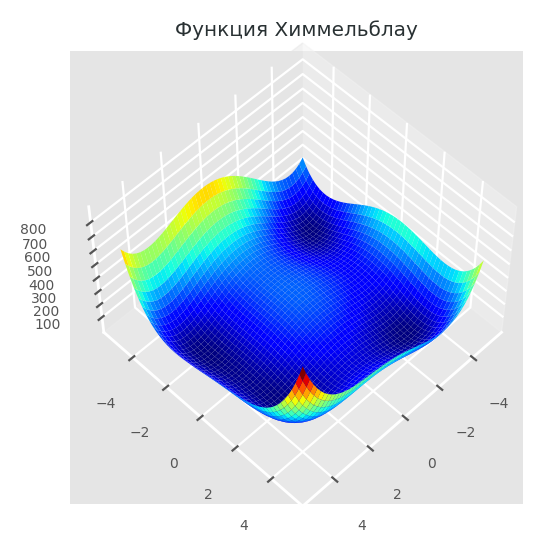

In [16]:
import functions.vanilla.Himmelblau as Himmelblau

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.view_init(55, 45)
basic_3d_plot(ax, lambda x, y: Himmelblau.f([x, y]), start=-5, stop=5, title="Функция Химмельблау")
plt.show()

Глобальные минимумы функции Химммельблау

$f(3, 2) = 0$

$f(-2.805118..., 3.131312...) = 0$

$f(-3.779310..., -3.283186...) = 0$

$f(3.584428..., -1.848126...) = 0$

1. Хотим найти минимум только с положительными координатами

In [26]:
from functions.torch.Himmelblau import THimmelblau
from scipy.optimize import Bounds

bounds = Bounds([0, 0], [+np.inf, +np.inf])

m = THimmelblau()
c = np.zeros(2)

res = minimize(m, c, method='L-BFGS-B', jac=m.jacobian, bounds=bounds)
minimize_print_status(res)

Успешно: True
Значение функции: 1.128459773951279e-14
Точка минимума: [3.         1.99999998]
Количество итераций метода: 10
Количество вызовов функции: 16
Посчитано якобианов: 16
Комментарий: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


2. Выразим следующие ограничения через LinearConstraint

* $0 \leq x < \infty$
* $x + 2y \leq 6$
* $y \leq 10$

Примечание: предыдущая найденная точка не совсем удовлетворяет этим условиям.

Запишем неравенства в матричной форме:

$$
\begin{bmatrix}
0\\
-\infty\\
-\infty
\end{bmatrix}

\leq

\begin{bmatrix}
1 & 0\\
1 & 2\\
0 & 1\\
\end{bmatrix}

\begin{bmatrix}
x\\
y
\end{bmatrix}

\leq

\begin{bmatrix}
\infty\\
6\\
10
\end{bmatrix}
$$

In [27]:
from scipy.optimize import LinearConstraint

linear_constraint = LinearConstraint([[1, 0], [1, 2], [0, 1]], [0, -np.inf, -np.inf], [np.inf, 6, 10])
res = minimize(m, c, method='SLSQP', jac=m.jacobian, constraints=linear_constraint)
minimize_print_status(res)

Успешно: True
Значение функции: 3.192565733205883
Точка минимума: [3.06321804 1.46839098]
Количество итераций метода: 6
Количество вызовов функции: 8
Посчитано якобианов: 6
Комментарий: Optimization terminated successfully


Мы нашли точку минимума в условиях линейных ограничений. Но на самом деле если бы поиск пошел в другом направлении, то мы бы нашли более выгодную для нас точку - подходящую под условия и являющуюся глобальным минимумом.

Стремились к точке $(3, 2)$, а могли найти $(3.584428, -1.848126)$, поэтому важно из какой точки мы начинаем поиск.

Сместим начальную точку на -0.5 по игреку.

In [28]:
res = minimize(m, np.array([0, -0.5]), method='SLSQP', jac=m.jacobian, constraints=linear_constraint)
minimize_print_status(res)

Успешно: True
Значение функции: 5.328388062459471e-09
Точка минимума: [ 3.58443656 -1.8481397 ]
Количество итераций метода: 11
Количество вызовов функции: 20
Посчитано якобианов: 11
Комментарий: Optimization terminated successfully


Теперь все хорошо.

3. Рассмотрим задание нелинейных ограничений для функции Розенброка с помощью Non-linear constraint.

* $x - 2sin(y) \leq 0$
* $x^2 + y^2 \leq 2$
* $x^2 - y^2 \leq 1$

Запишем ограничения в матричной форме:

$$ c(x) = \begin{bmatrix} x - 2sin(y)\\ x^2 + y^2\\ x^2 -y^2 \end{bmatrix} \leq \begin{bmatrix} 0\\ 2\\ 1 \end{bmatrix} $$

Определим якобиан для этого ограничения:

$$ J(x) = \begin{bmatrix} 1 & -2cos(y)\\ 2x & 2y\\ 2x & -2y \end{bmatrix}$$

In [29]:
from scipy.optimize import NonlinearConstraint

def c(x):
    return np.array([x[0] - 2*np.sin(x[1]), x[0]**2 + x[1]**2, x[0]**2 - x[1]**2])

def j(x):
    return np.array([[1, -2*np.cos(x[1])], [2*x[0], 2*x[1]], [2*x[0], -2*x[1]]])

nonlinear_constraint = NonlinearConstraint(c, -np.inf, [0, 2, 1], jac=j) # -np.inf сам отскейлится до вектора

In [30]:
m = TRozenbrock()
res = minimize(m, np.zeros(2), method='SLSQP', jac=m.jacobian, constraints=nonlinear_constraint)
minimize_print_status(res)

Успешно: True
Значение функции: 0.9529355593389038
Точка минимума: [0.05413593 0.02707127]
Количество итераций метода: 6
Количество вызовов функции: 8
Посчитано якобианов: 6
Комментарий: Optimization terminated successfully


Вероятно, это не то, чего мы ожидали, но стоит вспомнить, как выглядит сама функция Розенброка и внимательно посмотреть на ограничение, которое мы задали:

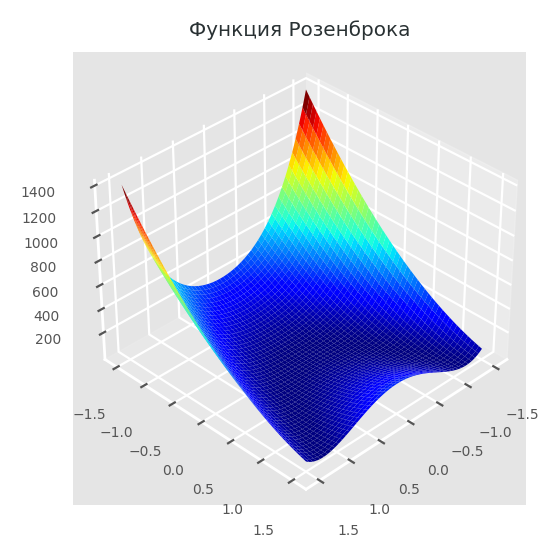

In [31]:
import functions.vanilla.Rozenbrock as Rozenbrock

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(projection='3d')
ax.view_init(35, 45)
basic_3d_plot(ax, lambda x, y: Rozenbrock.f([x, y]), start=-1.5, stop=1.5, title="Функция Розенброка")
plt.show()

![как выглядит на графике](../data/nonlinearconstraint.png)

Таким образом мы пойдем не по прямой (0, 0) -> (1, 1), а по кривой, и как раз эта кривая в заданные ограничения уже не укладывается.

Изменим начальную точку на (0.3, 0.3).

In [36]:
res = minimize(m, np.array([0.3, 0.3]), method='SLSQP', jac=m.jacobian, constraints=nonlinear_constraint)
minimize_print_status(res)

Успешно: True
Значение функции: 1.8337596974649356e-07
Точка минимума: [0.99958295 0.99915636]
Количество итераций метода: 19
Количество вызовов функции: 24
Посчитано якобианов: 19
Комментарий: Optimization terminated successfully


done.